## Tutorial: Rapid Teukolsky mode amplitudes

Waveforms are constructed from simulated trajectories by computing Teukolsky mode amplitudes $A_{\ell m k n}$ at the trajectory points $(p, e, x_I)$, conditioning on the MBH spin $a$. As the $A_{\ell m k n}$ are expensive to compute directly, in FEW we perform interpolation over pre-computed datasets in order to obtain mode amplitudes on a timescale of milliseconds.

In this short tutorial, we will review the tools provided in FEW for generating waveform mode amplitudes.

### Spline interpolation

FEW provides spline interpolation routines that are valid over a fixed domain of Kerr eccentric equatorial orbits, i.e. for varying $(a, p, e)$ and $|x_I|=1$. As mode amplitudes do not vary strongly with respect to $a$, we perform bicubic interpolation with respect to $(p,e)$ and linearly interpolate with respect to $a$. Mode indices $(\ell, m, n)$ in the set $\ell \in [2, 10]$, $m \in [-\ell, \ell]$, $n \in [-55, 55]$ are supported. A notable restriction is that currently only a single input (i.e., a float) for $a$ is supported.

For ease of waveform construction, we interpolate mode amplitudes that have been projected from the spin-weighted spheroidal harmonic basis to the spin-weighted _spherical_ harmonic basis (see e.g. [2102.02713](https://arxiv.org/abs/2102.02713), [2310.19706](https://arxiv.org/abs/2310.19706) and references therein). This basis admits the symmetry 

$$ A_{\ell -m -n} = (-1)^\ell A_{\ell m n}^*,$$

which we exploit in waveform generation in order to reduce the number of mode amplitude evaluations required. 

Once amplitude classes are instantiated, the necessary data files for interpolation are downloaded automatically. These can be reasonably large (a few GB), so ensure you are on a reasonably fast internet connection for your first run.

In [4]:
from few.amplitude.ampinterp2d import AmpInterpKerrEccEq
import numpy as np

kerr_amp_spline = AmpInterpKerrEccEq()

Specific modes can be selected by providing a list of tuples of $(\ell, m, n)$ values as the `specific_modes` kwarg.

Notice this returns a dictionary with keys as the mode tuple and values as the mode values.

In [2]:
# Get mode amplitudes at an example point
a = 0.87
p = 7.0
e = 0.4
xI = 1.0
specific_modes = [(2,2,0),(7,-3,1)]
specific_amplitudes = kerr_amp_spline(a, p, e, xI, specific_modes=specific_modes)
specific_amplitudes, specific_amplitudes[(2,2,0)]

({(2, 2, 0): array([0.21239204-0.06664877j]),
  (7, -3, 1): array([1.38197053e-06-1.77646921e-06j])},
 array([0.21239204-0.06664877j]))

If you call `kerr_amp_spline` without the key `specific_modes`, it will output all the modes:

In [3]:
all_amplitudes = kerr_amp_spline(a, p, e, xI)

One can easily retrieve a specific mode via the use of `special_index_map`.

In [5]:
# Extracting the (2,2,0) mode
mode_location = kerr_amp_spline.special_index_map[(2,2,0)]
np.allclose(
    specific_amplitudes[(2,2,0)], 
    all_amplitudes[0,mode_location]
    )

True

The arguments of `kerr_amp_spline` can also be arrays (with the exception of the spin, which must always be a float).

The data grids cannot generally be rectilinear in $(a, p, e)$ space, (for example to avoid computing the modes inside the separatrix). Instead, we start from a data points on a rectilinear grids $(u, w, y, z)$ all with ranges $[0, 1]$, and then map into space via the `apex_of_uwyz` utility:

In [6]:
import matplotlib.pyplot as plt
from few.utils.mappings.kerrecceq import apex_of_uwyz, z_of_a, y_of_x

# A rectilinear grid
uv = np.linspace(1e-5, 1 - 1e-5, 101)
wv = np.linspace(1e-5, 1 - 1e-5, 101)

a = 0.84
z = z_of_a(a)
y = y_of_x(1)

# For a given rectilinear grid, compute the associated (a,p,e,x) grid
u_grid, w_grid = np.asarray(np.meshgrid(uv, wv, indexing="ij")).reshape(2, -1)
a_grid, p_grid, e_grid, xI_grid = apex_of_uwyz(
    u_grid, w_grid, np.ones_like(u_grid) * y, np.ones_like(u_grid) * z
)

print("Total trajectory points:", w_grid.shape[0])

Total trajectory points: 10201


In [7]:
# All the mode amplitudes for the given (a,p,e,x) data points.
teuk_all_amps = kerr_amp_spline(a, p_grid, e_grid, xI_grid).reshape(
    uv.size, wv.size, -1
)

# Specific mode amplitudes for the given (a,p,e,x) data points.
specific_modes = [(2, 2, 0), (7, -3, 1)]
teuk_specific_amps = kerr_amp_spline(a, p_grid, e_grid, xI_grid, specific_modes=specific_modes)

# We can find the index to these modes to check
inds = np.array([kerr_amp_spline.special_index_map[lmn] for lmn in specific_modes])
print("Indices of interest:", inds)

# Making sure they are the same
print(
    np.allclose(
        teuk_specific_amps[(2, 2, 0)].reshape(uv.size, wv.size),
        teuk_all_amps[:, :, inds[0]],
    )
)

# to check -m modes we need to take the conjugate
print(
    np.allclose(
        teuk_specific_amps[(7, -3, 1)].reshape(uv.size, wv.size),
        np.conj(teuk_all_amps[:, :, inds[1]]),
    )
)


Indices of interest: [1165 3495]
True
False


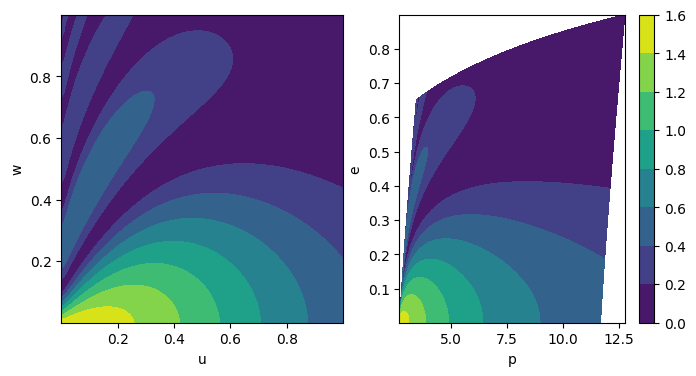

In [8]:
# Look at the contours of the (2,2,0) mode using teuk_all_amps
plt.figure(figsize=(8, 4))
plt.subplot(121)
cb = plt.contourf(
    u_grid.reshape(uv.size, wv.size),
    w_grid.reshape(uv.size, wv.size),
    np.abs(teuk_all_amps[:, :, kerr_amp_spline.special_index_map[(2, 2, 0)]]),
)
plt.xlabel("u")
plt.ylabel("w")
plt.subplot(122)
cb = plt.contourf(
    p_grid.reshape(uv.size, wv.size),
    e_grid.reshape(uv.size, wv.size),
    np.abs(teuk_all_amps[:, :, kerr_amp_spline.special_index_map[(2, 2, 0)]]),
)
plt.colorbar(cb)
plt.xlabel("p")
plt.ylabel("e")
plt.show()

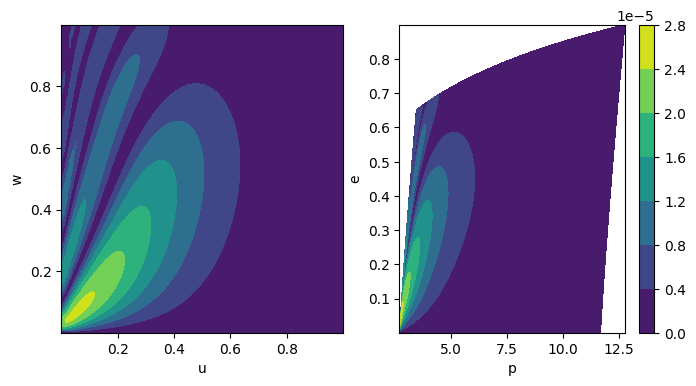

In [9]:
# Look at the contours of the (7,-3, 1) mode using teuk_specific_amps
plt.figure(figsize=(8, 4))
plt.subplot(121)
cb = plt.contourf(
    u_grid.reshape(uv.size, wv.size),
    w_grid.reshape(uv.size, wv.size),
    np.abs(teuk_specific_amps[(7, -3, 1)].reshape(uv.size, wv.size)),
)
plt.xlabel("u")
plt.ylabel("w")
plt.subplot(122)
cb = plt.contourf(
    p_grid.reshape(uv.size, wv.size),
    e_grid.reshape(uv.size, wv.size),
    np.abs(teuk_specific_amps[(7, -3, 1)].reshape(uv.size, wv.size)),
)
plt.colorbar(cb)
plt.xlabel("p")
plt.ylabel("e")
plt.show()

### ROMAN amplitude generation

ROMAN uses a reduced order model representing the mode amplitude space. It then trains a neural network on this reduced model. The neural network is evaluated and the resulting matrix is transformed from the reduced basis back to the full mode space.  

This approach for amplitude interpolation was the primary method used for the original Schwarzschild eccentric waveforms. It is retained for compatibility (both backwards and, perhaps, future). The interface is very similar to that of the spline interpolation classes.

In [5]:
from few.amplitude.romannet import RomanAmplitude

# initialize ROMAN class
amp = RomanAmplitude(buffer_length=5000)  # buffer_length creates memory buffers

Total trajectory points: 2500


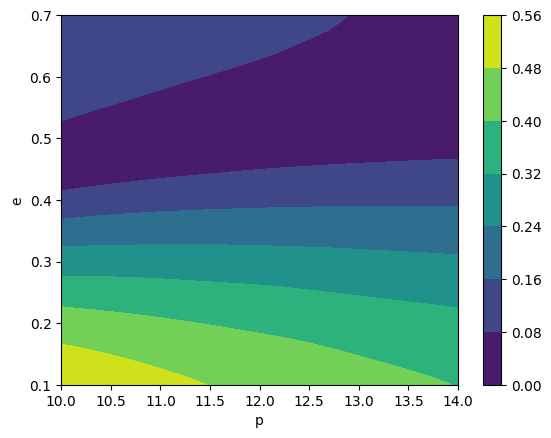

In [6]:
p = np.linspace(10.0, 14.0)
e = np.linspace(0.1, 0.7)

p_all, e_all = np.asarray([temp.ravel() for temp in np.meshgrid(p, e)])

print("Total trajectory points:", p_all.shape[0])
teuk_modes = amp(0.0, p_all, e_all, np.ones_like(p_all))  # a, p, e, xI

# look at the contours of the (2,2,0) mode
cb = plt.contourf(
    p,
    e,
    np.abs(teuk_modes[:, amp.special_index_map[(2, 2, 0)]].reshape(len(p), len(e))),
)
plt.colorbar(cb)
plt.xlabel("p")
plt.ylabel("e")
plt.show()